In [29]:
import requests
import time
import math
from pathlib import Path
import pandas as pd
# from tqdm.notebook import tqdm
from datasets import load_dataset
# from huggingface_hub import list_datasets
# from datasets import load_metric
import torch
import json
import os
from transformers import DistilBertTokenizerFast, AutoTokenizer, BertForQuestionAnswering
from transformers import DistilBertForQuestionAnswering, AutoModelForQuestionAnswering
from transformers import get_scheduler
from transformers import pipeline
from transformers import DefaultDataCollator
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm.auto import tqdm
import collections
import numpy as np
import evaluate

In [22]:
def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
        # if None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

def QAinference(model, tokenizer, question, context, device, usepipeline=True):
    if usepipeline ==True:
        if device.type == 'cuda':
            question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0) #device=0 means cuda
        else:
            question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer) 
        answers=question_answerer(question=question, context=context)
        print(answers) #'answer', 'score', 'start', 'end'
    else:
        inputs = tokenizer(question, context, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        #Get the highest probability from the model output for the start and end positions:
        answer_start_index = outputs.start_logits.argmax()
        answer_end_index = outputs.end_logits.argmax()
        #predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
        #Decode the predicted tokens to get the answer:
        predict_answer_tokens = inputs['input_ids'][0, answer_start_index : answer_end_index + 1]
        answers=tokenizer.decode(predict_answer_tokens)
        print(answers)
    return answers

max_length = 384
stride = 128
def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping") #new add
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i] #new add
        #answer = answers[i]
        answer = answers[sample_idx] # sample_idx from sample_map
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        # if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]] #100 questions
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")#100, if no overflow, then sample_map=0-99
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx]) #get example id strings

        sequence_ids = inputs.sequence_ids(i) #[None, 0... None, 1... 1]
        offset = inputs["offset_mapping"][i] #100 size array of tuple (0, 4)
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ] #put None in sequence_id==1, i.e., put questions to None

    inputs["example_id"] = example_ids #string list
    return inputs

def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

def testdataset(raw_datasets):
    oneexample = raw_datasets["train"][0]
    #'id', 'title','context', 'question', 'answers' (text, answer_start),  
    print("Context: ", oneexample["context"])
    print("Question: ", oneexample["question"])
    print("Answer: ", oneexample["answers"])#dict with 'text' (list of strings) and 'answer_start' list of integer [515]
    #During training, there is only one possible answer. We can double-check this by using the Dataset.filter() method:
    print(raw_datasets["train"].filter(lambda x: len(x["answers"]["text"]) != 1))
    #For evaluation, however, there are several possible answers for each sample, which may be the same or different:
    valkey="validation" #'test' #"validation"
    print(raw_datasets[valkey][0]["answers"])
    print(raw_datasets[valkey][2]["answers"])

    #We can pass to our tokenizer the question and the context together, and it will properly insert the special tokens [CLS], [SEP]
    inputs = tokenizer(oneexample["question"], oneexample["context"])
    print(tokenizer.decode(inputs["input_ids"])) #[CLS] question [SEP] xxxx [SEP]
    #The labels will then be the index of the tokens starting and ending the answer

    #deal with very long contexts, use sliding window
    inputs = tokenizer(
        oneexample["question"],
        oneexample["context"],
        max_length=100,
        truncation="only_second", #truncate the context (in the second position)
        stride=50, #use a sliding window of 50 tokens
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
    )
    print(inputs.keys()) #['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping']
    for ids in inputs["input_ids"]: #4 features with overlaps
        print(tokenizer.decode(ids))
        #split into four inputs, each of them containing the question and some part of the context.
        #some training examples where the answer is not included in the context: labels will be start_position = end_position = 0 (so we predict the [CLS] token)
    

    multiexamples = raw_datasets["train"][2:6]
    inputs = tokenizer(
        multiexamples["question"],
        multiexamples["context"],
        max_length=100,
        truncation="only_second",
        stride=50,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
    )
    print(f"The 4 examples gave {len(inputs['input_ids'])} features.") #17 features
    print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.") #[0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3]
    #'overflow_to_sample_mapping': one example might give us several features if it has a long context, e.g. 0 example has been split into 5 parts
    #'offset_mapping': [[(0,0),(0,3),(3,4)...] ] The offset mappings will give us a map from token to character position in the original context. help us compute the start_positions and end_positions.

    answers = multiexamples["answers"] #length of 4 
    start_positions = []
    end_positions = []
    print(inputs["offset_mapping"]) #size 17
    for i, offset in enumerate(inputs["offset_mapping"]): #17 array, each array (offset) has 100 elements tuples of two integers representing the span of characters inside the original context.
        sample_idx = inputs["overflow_to_sample_mapping"][i] #0 current feature map to which sample
        answer = answers[sample_idx] #get the groundtruth answer in sample idx
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i) #[None 0 0... None 1 1 1... None], 100 tokens belongs to 0 or 1 or None

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx #sequence 1 starts at 17th token
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1 #98

        # If the answer is not fully inside the context, label is (0, 0); offset[context_start] in the first part is (0,13), second part is (156, 160), (438, 440)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char: #answer not in this region
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start #17
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1) #find the answer start token index

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1) #find the answer end token index

    print(start_positions) #17 elements, if position is 0, means no answer in this region
    print(end_positions)

    idx = 0 #use idx=0 as example
    sample_idx = inputs["overflow_to_sample_mapping"][idx] #0-th sample
    answer = answers[sample_idx]["text"][0] #ground truth answer text
    start = start_positions[idx]
    end = end_positions[idx]
    labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])
    print(f"Theoretical answer: {answer}, labels give: {labeled_answer}")

    idx = 4 #use idx=4 as example
    sample_idx = inputs["overflow_to_sample_mapping"][idx] #sample_idx is 1
    answer = answers[sample_idx]["text"][0]
    start = start_positions[idx]
    end = end_positions[idx]
    labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])
    print(f"Theoretical answer: {answer}, labels give: {labeled_answer}")
    #means the answer is not in the context chunk of that feature

def compute_metrics(start_logits, end_logits, features, examples):
    n_best = 20
    max_answer_length = 30

    #features is after tokenization, examples are original dataset
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

## Load Dataset

In [ ]:
# Load a dataset and print the first example in the training set
squad_dataset = load_dataset('squad')
print(squad_dataset['train'][0])

{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}


## Model 1

In [74]:
# Model 1: "deepset/bert-base-cased-squad2"

tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2")
model = AutoModelForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2")

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [75]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [50]:
valkeyname="validation" #"test"
tokenized_datasets = {}
tokenized_datasets["train"] = squad_dataset["train"].map(preprocess_training_examples, batched=True, remove_columns=squad_dataset["train"].column_names)
#['input_ids', 'attention_mask', 'start_positions', 'end_positions']
small_eval_set = squad_dataset[valkeyname].select(range(100))
validation_dataset = small_eval_set.map(
    preprocess_validation_examples, #preprocess_function, #preprocess_validation_examples,
    batched=True,
    remove_columns=squad_dataset[valkeyname].column_names,
)
print(len(squad_dataset[valkeyname])) #1000
print(len(validation_dataset)) #1011
eval_set_for_model = validation_dataset.remove_columns(["example_id", "offset_mapping"])
print(validation_dataset.features.keys())#['input_ids', 'attention_mask', 'offset_mapping', 'example_id']
print(eval_set_for_model.features.keys())#['input_ids', 'attention_mask']
eval_set_for_model.set_format("torch")

Map: 100%|██████████| 100/100 [00:00<00:00, 1562.25 examples/s]

10570
100
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [51]:
data_collator = DefaultDataCollator()
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=8, shuffle=True, collate_fn=data_collator)
eval_dataloader = DataLoader(
    eval_set_for_model, batch_size=8, collate_fn=data_collator
)

In [32]:
metric = evaluate.load("squad")

In [ ]:
# Model 1

valkeyname="validation" #"test"
tokenized_datasets = {}
tokenized_datasets["train"] = squad_dataset["train"].map(preprocess_training_examples, batched=True, remove_columns=squad_dataset["train"].column_names)
#['input_ids', 'attention_mask', 'start_positions', 'end_positions']
small_eval_set = squad_dataset[valkeyname].select(range(100))
validation_dataset = small_eval_set.map(
    preprocess_validation_examples, #preprocess_function, #preprocess_validation_examples,
    batched=True,
    remove_columns=squad_dataset[valkeyname].column_names,
)
print(len(squad_dataset[valkeyname])) #1000
print(len(validation_dataset)) #1011
eval_set_for_model = validation_dataset.remove_columns(["example_id", "offset_mapping"])
print(validation_dataset.features.keys())#['input_ids', 'attention_mask', 'offset_mapping', 'example_id']
print(eval_set_for_model.features.keys())#['input_ids', 'attention_mask']
eval_set_for_model.set_format("torch")

Map: 100%|██████████| 100/100 [00:00<00:00, 1562.25 examples/s]

10570
100
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [ ]:
data_collator = DefaultDataCollator()
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=8, shuffle=True, collate_fn=data_collator)
eval_dataloader = DataLoader(
    eval_set_for_model, batch_size=8, collate_fn=data_collator
)

In [52]:
# Model 1 evaluation
model.eval()

num_val_steps = len(eval_dataloader)
valprogress_bar = tqdm(range(num_val_steps))
start_logits = []
end_logits = []
for batch in eval_dataloader:
    #batch = {k: batch[k].to(device) for k in batch.column_names}
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    start_logits.append(outputs.start_logits.cpu().numpy())
    end_logits.append(outputs.end_logits.cpu().numpy())
start_logits = np.concatenate(start_logits) #8, 384 array to (102,384)
end_logits = np.concatenate(end_logits)
dataset_len=len(validation_dataset) #103
start_logits = start_logits[: dataset_len]
end_logits = end_logits[: dataset_len]
metrics1 = compute_metrics(
    start_logits, end_logits, validation_dataset, squad_dataset[valkeyname]
)
print(metrics1)

100%|██████████| 10570/10570 [00:01<00:00, 9470.85it/s] 


{'exact_match': 0.6149479659413434, 'f1': 0.6551353040585767}


### Model 2

In [81]:
# Model 2: "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
     

In [83]:
# Model 2

valkeyname="validation" #"test"
tokenized_datasets = {}
tokenized_datasets["train"] = squad_dataset["train"].map(preprocess_training_examples, batched=True, remove_columns=squad_dataset["train"].column_names)
#['input_ids', 'attention_mask', 'start_positions', 'end_positions']
small_eval_set = squad_dataset[valkeyname].select(range(100))
validation_dataset = small_eval_set.map(
    preprocess_validation_examples, #preprocess_function, #preprocess_validation_examples,
    batched=True,
    remove_columns=squad_dataset[valkeyname].column_names,
)
print(len(squad_dataset[valkeyname])) #1000
print(len(validation_dataset)) #1011
eval_set_for_model = validation_dataset.remove_columns(["example_id", "offset_mapping"])
print(validation_dataset.features.keys())#['input_ids', 'attention_mask', 'offset_mapping', 'example_id']
print(eval_set_for_model.features.keys())#['input_ids', 'attention_mask']
eval_set_for_model.set_format("torch")

10570
100
dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'example_id'])
dict_keys(['input_ids', 'attention_mask'])


In [84]:
data_collator = DefaultDataCollator()
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=8, shuffle=True, collate_fn=data_collator)
eval_dataloader = DataLoader(
    eval_set_for_model, batch_size=8, collate_fn=data_collator
)

In [85]:
# Model 2 evaluation
model.eval()

num_val_steps = len(eval_dataloader)
valprogress_bar = tqdm(range(num_val_steps))
start_logits = []
end_logits = []
for batch in eval_dataloader:
    #batch = {k: batch[k].to(device) for k in batch.column_names}
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    start_logits.append(outputs.start_logits.cpu().numpy())
    end_logits.append(outputs.end_logits.cpu().numpy())
start_logits = np.concatenate(start_logits) #8, 384 array to (102,384)
end_logits = np.concatenate(end_logits)
dataset_len=len(validation_dataset) #103
start_logits = start_logits[: dataset_len]
end_logits = end_logits[: dataset_len]
metrics2 = compute_metrics(
    start_logits, end_logits, validation_dataset, squad_dataset[valkeyname]
)
print(metrics2)


100%|██████████| 10570/10570 [00:01<00:00, 9311.19it/s] 


{'exact_match': 0.02838221381267739, 'f1': 0.05430206448974767}


## Models Evaluation

In [57]:
models = ['bert-base-cased-squad2', 'distilbert-base-uncased']
eval_result = {
    'Model': models,
    'exact_match': [metrics1['exact_match'], metrics2['exact_match']],
    'F1 Score': [metrics1['f1'], metrics2['f1']]
}
df_model_evaluation = pd.DataFrame(eval_result).set_index('Model')
df_model_evaluation

,exact_match,F1 Score
Model,,
bert-base-cased-squad2,0.614948,0.655135
distilbert-base-uncased,0.028382,0.067235


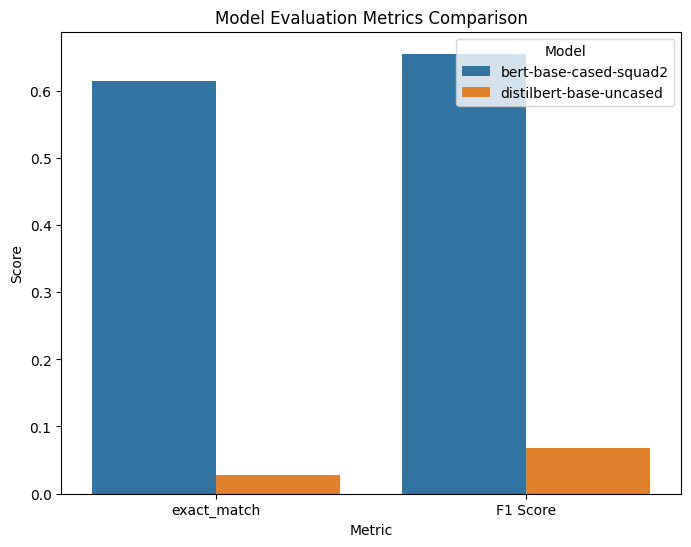

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index to have 'Model' as a column
df_plot = df_model_evaluation.reset_index()

# Melt the DataFrame for easier plotting
df_melted = df_plot.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted)
plt.title('Model Evaluation Metrics Comparison')
plt.ylabel('Score')
plt.savefig('QAModels_Evaluation.png')
plt.show()

## Train distilbert-base-uncased model

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        #batch = {k: v.to(device) for k, v in batch.items()}
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        #outputs = model(**batch)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        #sequence classification: outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss = outputs[0] #same loss results
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        
        progress_bar.update(1)

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []
    num_val_steps = len(eval_dataloader)
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        start_logits.append(outputs.start_logits.cpu().numpy())
        end_logits.append(outputs.end_logits.cpu().numpy())
    start_logits = np.concatenate(start_logits) #8, 384 array to (102,384)
    end_logits = np.concatenate(end_logits)
    dataset_len=len(validation_dataset) #103
    start_logits = start_logits[: dataset_len]
    end_logits = end_logits[: dataset_len]
    metrics = compute_metrics(
        start_logits, end_logits, validation_dataset, squad_dataset[valkeyname]
    )
    print(f"epoch {epoch}:", metrics)

outputpath='./output/distilbert-base-uncased/'
tokenizer.save_pretrained(outputpath)
torch.save(model.state_dict(), os.path.join(outputpath, 'savedmodel.pth'))

In [ ]:
# Model 2 evaluation after training
model.eval()

num_val_steps = len(eval_dataloader)
valprogress_bar = tqdm(range(num_val_steps))
start_logits = []
end_logits = []
for batch in eval_dataloader:
    #batch = {k: batch[k].to(device) for k in batch.column_names}
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    start_logits.append(outputs.start_logits.cpu().numpy())
    end_logits.append(outputs.end_logits.cpu().numpy())
start_logits = np.concatenate(start_logits) #8, 384 array to (102,384)
end_logits = np.concatenate(end_logits)
dataset_len=len(validation_dataset) #103
start_logits = start_logits[: dataset_len]
end_logits = end_logits[: dataset_len]
metrics3 = compute_metrics(
    start_logits, end_logits, validation_dataset, squad_dataset[valkeyname]
)
print(metrics3)

In [ ]:
models = ['bert-base-cased-squad2', 'distilbert-base-uncased', 'distilbert-base-uncased_fine_tuning']
eval_result = {
    'Model': models,
    'exact_match': [metrics1['exact_match'], metrics2['exact_match'], metrics3['exact_match']],
    'F1 Score': [metrics1['f1'], metrics2['f1'], metrics3['f1']]
}
df_model_evaluation = pd.DataFrame(eval_result).set_index('Model')
df_model_evaluation

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index to have 'Model' as a column
df_plot = df_model_evaluation.reset_index()

# Melt the DataFrame for easier plotting
df_melted = df_plot.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted)
plt.title('Model Evaluation Metrics Comparison')
plt.ylabel('Score')
plt.savefig('QAModels_Evaluation_fine_tuning.png')